<a href="https://colab.research.google.com/github/KateJud/MicroproectABS/blob/main/Yudina_2__192__ml4se.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 2
Train FFNN, beat baselines.
You can use Google Collab, Kaggle kernels or any other devices.
Here you can use only numpy, pandas, sklearn and pytorch

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# fix SEED for reproducible experiment
SEED = 42
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

print(np.__version__, torch.__version__)

1.19.5 1.9.0+cu111


In [3]:
# toy dataset from https://github.com/greydanus/mnist1d

import requests, pickle

url = 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'
r = requests.get(url, allow_redirects=True)
open('./mnist1d_data.pkl', 'wb').write(r.content)

with open('./mnist1d_data.pkl', 'rb') as handle:
    data = pickle.load(handle)

In [4]:
X_train, y_train = data['x'], data['y'].reshape(-1,1)
X_test, y_test = data['x_test'], data['y_test'].reshape(-1,1)

# create validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.1, stratify=y_train, 
                                                 random_state=SEED)
    
print('train data shape:{} # classes {}'.format(X_train.shape, len(np.unique(y_train))))
print('validation data size:{}'.format(X_val.shape[0]))
print('test data size:{}'.format(X_test.shape[0]))

train data shape:(3600, 40) # classes 10
validation data size:400
test data size:1000


In [5]:
# batch size is an important hyperparameter
# make sure you have enough memory to contain batch data and the model
batch_size = 64

train_loader = DataLoader(TensorDataset(
    torch.from_numpy(X_train).float(), 
    torch.from_numpy(y_train)),
    batch_size=batch_size, 
    shuffle=True # it's important to shuffle train dataset every epoch
    )

val_loader = DataLoader(TensorDataset(
    torch.from_numpy(X_val).float(), 
    torch.from_numpy(y_val)),
    batch_size=batch_size, 
    shuffle=False 
)


test_loader = DataLoader(TensorDataset(
    torch.from_numpy(X_test).float(), 
    torch.from_numpy(y_test)),
    batch_size=batch_size, 
    shuffle=False 
)

###Task 1 (2 points)
Implement early stopping

In [21]:
def train(model, train_loader, val_loader, n_epochs, criterion, device, checkdir=None, patience=0):
    """
    train_loader: loader of train dataset
    val_loader: loader of validation dataset
    n_epochs: max epochs to train
    device: cpu or gpu
    checkdir: folder to save model weights
    patience: how many epochs we tolerate the increasing validation loss
    """
    history = []
    
    # number of batches in an epoch
    n_batches = int(np.ceil(len(train_loader.dataset) / batch_size))

    prev_val_loss=-1
    epoch_escape=0
    for epoch in range(n_epochs):

        # training mode: affects BatchNorm, Dropout, etc.
        model.train()

        # make progressbar
        batch_iter = tqdm(enumerate(train_loader), total=n_batches, desc='epoch %d' % (epoch + 1), leave=True)

        train_loss = 0
        for i, (X, y) in batch_iter:

            # move data to selected device
            X = X.to(device)
            y = y.to(device)

            # set weight gradient to 0
            optimizer.zero_grad()

            # make forward pass
            prediction = model(X)

            # compute loss
            loss = criterion(prediction, y.squeeze())

            # make backward pass: compute gradient for each weight
            loss.backward()
            # make optimization step
            optimizer.step()

            # average train loss
            train_loss = train_loss*i/(i+1) + loss.data.cpu().detach().item()/(i+1)

            batch_iter.set_postfix(loss='%.4f' % train_loss)

        # inference mode: affects BatchNorm, Dropout, etc. 
        model.eval()
        val_loss = []

        # we don't update weights on inference: no need for gradient
        with torch.no_grad():
            for X, y in val_loader:
                # move data to selected device
                X = X.to(device)
                y = y.to(device)

                # make prediction
                prediction = model(X)
                loss = criterion(prediction, y.squeeze())
                # move batch loss from device to cpu
                loss = loss.data.cpu().detach().item()
                val_loss.append( loss )

        val_loss = np.mean(val_loss)
        
        # TODO: early stopping
        if(prev_val_loss!=-1 and val_loss>prev_val_loss):
          if(epoch_escape<patience):
            epoch_escape+=1
          else:
            print("Early stopping")
            break;

        print('validation loss=%.4f' % val_loss)
        
        # save model weights on each epoch
        if checkdir:
            torch.save(model.state_dict(), checkdir + '/epoch_%d_val_loss_%f' % (epoch, val_loss))

        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
        })
        prev_val_loss=val_loss

    return pd.DataFrame(history)

In [22]:
class FFNN(nn.Module):
    
    def __init__(self, input_size, output_size, h_size, n_blocks, dropout_p):
        """
        input_size: number of features
        output_size: number of classes
        h_size: size of hidden layer
        n_blocks: number of hidden layers
        dropout_p: dropout rate
        """
        super(FFNN, self).__init__()
        
        self.mlp = [
            # normalize input
            nn.BatchNorm1d(input_size),
            # project data into hidden feature space
            nn.Linear(input_size, h_size),
            # some activation funtion
            nn.PReLU(),
            nn.Dropout(dropout_p),
        ]
        
        # "basic" blocks
        for i in range(n_blocks):
            self.mlp.extend([
                nn.Linear(h_size,h_size),
                nn.BatchNorm1d(h_size),
                nn.PReLU(),
                nn.Dropout(dropout_p),
            ])
            
        # output layer: classification
        self.mlp.append(nn.Linear(h_size, output_size))
        self.mlp = nn.Sequential(*self.mlp)
        
        

    def forward(self, x):
        x = self.mlp(x)
        return x

In [23]:
# clean checkpoint directory
!rm -rf checkdir
!mkdir checkdir

In [24]:
device = torch.device('cuda')
# device = torch.device('cpu')
checkdir = 'checkdir'

# create model
model = FFNN(
    input_size=X_train.shape[1],
    output_size=len(np.unique(y_train)),
    h_size=100,
    n_blocks=1,
    dropout_p=0.1)

# move model to device
model = model.to(device)

# create optimizer.
optimizer = optim.Adam(model.parameters())
# select loss function
criterion = nn.CrossEntropyLoss()

# train the model
history = train(model, train_loader, val_loader, n_epochs=50, 
      criterion=criterion, device=device, checkdir=checkdir)

epoch 1: 100%|██████████| 57/57 [00:00<00:00, 94.53it/s, loss=1.9677]


validation loss=1.8254


epoch 2: 100%|██████████| 57/57 [00:00<00:00, 92.90it/s, loss=1.6839]


validation loss=1.6669


epoch 3: 100%|██████████| 57/57 [00:00<00:00, 97.55it/s, loss=1.5573] 


validation loss=1.5416


epoch 4: 100%|██████████| 57/57 [00:00<00:00, 102.27it/s, loss=1.4509]


validation loss=1.4707


epoch 5: 100%|██████████| 57/57 [00:00<00:00, 97.36it/s, loss=1.3958]


validation loss=1.4359


epoch 6: 100%|██████████| 57/57 [00:00<00:00, 99.72it/s, loss=1.3466] 


validation loss=1.3757


epoch 7: 100%|██████████| 57/57 [00:00<00:00, 95.82it/s, loss=1.2675]


validation loss=1.3336


epoch 8: 100%|██████████| 57/57 [00:00<00:00, 96.93it/s, loss=1.2333]


validation loss=1.3023


epoch 9: 100%|██████████| 57/57 [00:00<00:00, 102.32it/s, loss=1.1858]


validation loss=1.2702


epoch 10: 100%|██████████| 57/57 [00:00<00:00, 97.33it/s, loss=1.1443]


validation loss=1.2172


epoch 11: 100%|██████████| 57/57 [00:00<00:00, 98.59it/s, loss=1.1091]


Early stopping


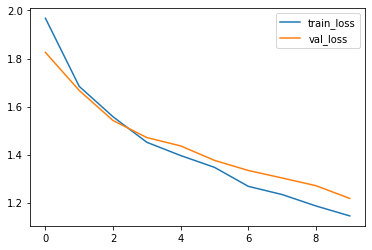

In [25]:
# plot validation curve
history[['train_loss', 'val_loss']].plot();

###Task 2 (2 points)
Make the model severely overfit

In [61]:
# TODO: create loaders
# TODO: create model
# TODO: train model

# batch size is an important hyperparameter
# make sure you have enough memory to contain batch data and the model
batch_size = 120

train_loader = DataLoader(TensorDataset(
    torch.from_numpy(X_train).float(), 
    torch.from_numpy(y_train)),
    batch_size=batch_size, 
    shuffle=True # it's important to shuffle train dataset every epoch
    )

val_loader = DataLoader(TensorDataset(
    torch.from_numpy(X_val).float(), 
    torch.from_numpy(y_val)),
    batch_size=batch_size, 
    shuffle=False 
)


test_loader = DataLoader(TensorDataset(
    torch.from_numpy(X_test).float(), 
    torch.from_numpy(y_test)),
    batch_size=batch_size, 
    shuffle=False 
)

In [62]:
history = train(model, train_loader, val_loader, n_epochs=100, 
      criterion=criterion, device=device, checkdir=checkdir, patience=100)

if history['val_loss'].iloc[-1] - history['train_loss'].iloc[-1] > 1.0:
    print('success!')

epoch 1: 100%|██████████| 30/30 [00:00<00:00, 102.24it/s, loss=0.1329]


validation loss=1.0770


epoch 2: 100%|██████████| 30/30 [00:00<00:00, 100.96it/s, loss=0.1281]


validation loss=1.0897


epoch 3: 100%|██████████| 30/30 [00:00<00:00, 96.16it/s, loss=0.1102]


validation loss=1.1017


epoch 4: 100%|██████████| 30/30 [00:00<00:00, 102.93it/s, loss=0.1211]


validation loss=1.0786


epoch 5: 100%|██████████| 30/30 [00:00<00:00, 103.53it/s, loss=0.1322]


validation loss=1.1032


epoch 6: 100%|██████████| 30/30 [00:00<00:00, 100.61it/s, loss=0.1234]


validation loss=1.1005


epoch 7: 100%|██████████| 30/30 [00:00<00:00, 105.99it/s, loss=0.1155]


validation loss=1.1265


epoch 8: 100%|██████████| 30/30 [00:00<00:00, 99.07it/s, loss=0.1326]


validation loss=1.1063


epoch 9: 100%|██████████| 30/30 [00:00<00:00, 100.70it/s, loss=0.1318]


validation loss=1.0764


epoch 10: 100%|██████████| 30/30 [00:00<00:00, 100.87it/s, loss=0.1350]


validation loss=1.0968


epoch 11: 100%|██████████| 30/30 [00:00<00:00, 100.28it/s, loss=0.1111]


validation loss=1.1003


epoch 12: 100%|██████████| 30/30 [00:00<00:00, 102.64it/s, loss=0.1226]


validation loss=1.0659


epoch 13: 100%|██████████| 30/30 [00:00<00:00, 87.35it/s, loss=0.1359]


validation loss=1.0854


epoch 14: 100%|██████████| 30/30 [00:00<00:00, 99.96it/s, loss=0.1353]


validation loss=1.0859


epoch 15: 100%|██████████| 30/30 [00:00<00:00, 92.71it/s, loss=0.1489]


validation loss=1.0996


epoch 16: 100%|██████████| 30/30 [00:00<00:00, 98.95it/s, loss=0.1250] 


validation loss=1.1077


epoch 17: 100%|██████████| 30/30 [00:00<00:00, 96.78it/s, loss=0.1327]


validation loss=1.0750


epoch 18: 100%|██████████| 30/30 [00:00<00:00, 92.43it/s, loss=0.1276]


validation loss=1.0614


epoch 19: 100%|██████████| 30/30 [00:00<00:00, 100.63it/s, loss=0.1188]


validation loss=1.0708


epoch 20: 100%|██████████| 30/30 [00:00<00:00, 102.77it/s, loss=0.1402]


validation loss=1.0665


epoch 21: 100%|██████████| 30/30 [00:00<00:00, 91.60it/s, loss=0.1370]


validation loss=1.1035


epoch 22: 100%|██████████| 30/30 [00:00<00:00, 100.33it/s, loss=0.1253]


validation loss=1.0882


epoch 23: 100%|██████████| 30/30 [00:00<00:00, 94.79it/s, loss=0.1326]


validation loss=1.1141


epoch 24: 100%|██████████| 30/30 [00:00<00:00, 100.36it/s, loss=0.1288]


validation loss=1.0812


epoch 25: 100%|██████████| 30/30 [00:00<00:00, 92.62it/s, loss=0.1254]


validation loss=1.0897


epoch 26: 100%|██████████| 30/30 [00:00<00:00, 94.47it/s, loss=0.1401]


validation loss=1.0752


epoch 27: 100%|██████████| 30/30 [00:00<00:00, 103.68it/s, loss=0.1210]


validation loss=1.1117


epoch 28: 100%|██████████| 30/30 [00:00<00:00, 101.30it/s, loss=0.1295]


validation loss=1.0969


epoch 29: 100%|██████████| 30/30 [00:00<00:00, 97.22it/s, loss=0.1304]


validation loss=1.0976


epoch 30: 100%|██████████| 30/30 [00:00<00:00, 98.09it/s, loss=0.1191]


validation loss=1.1190


epoch 31: 100%|██████████| 30/30 [00:00<00:00, 91.73it/s, loss=0.1418]


validation loss=1.1225


epoch 32: 100%|██████████| 30/30 [00:00<00:00, 96.87it/s, loss=0.1121]


validation loss=1.1070


epoch 33: 100%|██████████| 30/30 [00:00<00:00, 93.52it/s, loss=0.1338]


validation loss=1.0748


epoch 34: 100%|██████████| 30/30 [00:00<00:00, 100.47it/s, loss=0.1319]


validation loss=1.0767


epoch 35: 100%|██████████| 30/30 [00:00<00:00, 92.53it/s, loss=0.1227]


validation loss=1.1098


epoch 36: 100%|██████████| 30/30 [00:00<00:00, 98.75it/s, loss=0.1189]


validation loss=1.1171


epoch 37: 100%|██████████| 30/30 [00:00<00:00, 97.57it/s, loss=0.1371]


validation loss=1.1039


epoch 38: 100%|██████████| 30/30 [00:00<00:00, 97.58it/s, loss=0.1302]


validation loss=1.1546


epoch 39: 100%|██████████| 30/30 [00:00<00:00, 95.67it/s, loss=0.1151]


validation loss=1.1118


epoch 40: 100%|██████████| 30/30 [00:00<00:00, 96.70it/s, loss=0.1330]


validation loss=1.1069


epoch 41: 100%|██████████| 30/30 [00:00<00:00, 96.88it/s, loss=0.1454]


validation loss=1.1675


epoch 42: 100%|██████████| 30/30 [00:00<00:00, 93.16it/s, loss=0.1257]


validation loss=1.1630


epoch 43: 100%|██████████| 30/30 [00:00<00:00, 102.78it/s, loss=0.1314]


validation loss=1.1374


epoch 44: 100%|██████████| 30/30 [00:00<00:00, 99.47it/s, loss=0.1282]


validation loss=1.1168


epoch 45: 100%|██████████| 30/30 [00:00<00:00, 91.82it/s, loss=0.1260]


validation loss=1.1257


epoch 46: 100%|██████████| 30/30 [00:00<00:00, 89.83it/s, loss=0.1448]


validation loss=1.1934


epoch 47: 100%|██████████| 30/30 [00:00<00:00, 100.36it/s, loss=0.1191]


validation loss=1.1301


epoch 48: 100%|██████████| 30/30 [00:00<00:00, 100.23it/s, loss=0.1291]


validation loss=1.1628


epoch 49: 100%|██████████| 30/30 [00:00<00:00, 103.25it/s, loss=0.1223]


validation loss=1.1313


epoch 50: 100%|██████████| 30/30 [00:00<00:00, 100.66it/s, loss=0.1272]


validation loss=1.1406


epoch 51: 100%|██████████| 30/30 [00:00<00:00, 90.99it/s, loss=0.1260]


validation loss=1.1372


epoch 52: 100%|██████████| 30/30 [00:00<00:00, 93.44it/s, loss=0.1275]


validation loss=1.1658


epoch 53: 100%|██████████| 30/30 [00:00<00:00, 95.15it/s, loss=0.1216]


validation loss=1.1665


epoch 54: 100%|██████████| 30/30 [00:00<00:00, 95.73it/s, loss=0.1164]


validation loss=1.1518


epoch 55: 100%|██████████| 30/30 [00:00<00:00, 96.68it/s, loss=0.1093] 


validation loss=1.1930


epoch 56: 100%|██████████| 30/30 [00:00<00:00, 98.91it/s, loss=0.1404] 


validation loss=1.1636


epoch 57: 100%|██████████| 30/30 [00:00<00:00, 98.31it/s, loss=0.1337]


validation loss=1.1291


epoch 58: 100%|██████████| 30/30 [00:00<00:00, 103.59it/s, loss=0.1306]


validation loss=1.1711


epoch 59: 100%|██████████| 30/30 [00:00<00:00, 94.68it/s, loss=0.1296]


validation loss=1.0930


epoch 60: 100%|██████████| 30/30 [00:00<00:00, 95.09it/s, loss=0.1208]


validation loss=1.1243


epoch 61: 100%|██████████| 30/30 [00:00<00:00, 101.75it/s, loss=0.1194]


validation loss=1.1314


epoch 62: 100%|██████████| 30/30 [00:00<00:00, 94.22it/s, loss=0.1296]


validation loss=1.0850


epoch 63: 100%|██████████| 30/30 [00:00<00:00, 95.47it/s, loss=0.1162]


validation loss=1.1009


epoch 64: 100%|██████████| 30/30 [00:00<00:00, 103.28it/s, loss=0.1186]


validation loss=1.1235


epoch 65: 100%|██████████| 30/30 [00:00<00:00, 96.13it/s, loss=0.1287]


validation loss=1.1215


epoch 66: 100%|██████████| 30/30 [00:00<00:00, 99.51it/s, loss=0.1150]


validation loss=1.1083


epoch 67: 100%|██████████| 30/30 [00:00<00:00, 90.20it/s, loss=0.1214]


validation loss=1.1081


epoch 68: 100%|██████████| 30/30 [00:00<00:00, 94.37it/s, loss=0.1292]


validation loss=1.1043


epoch 69: 100%|██████████| 30/30 [00:00<00:00, 85.92it/s, loss=0.1161]


validation loss=1.0987


epoch 70: 100%|██████████| 30/30 [00:00<00:00, 93.21it/s, loss=0.1254]


validation loss=1.0979


epoch 71: 100%|██████████| 30/30 [00:00<00:00, 102.74it/s, loss=0.1206]


validation loss=1.1041


epoch 72: 100%|██████████| 30/30 [00:00<00:00, 100.61it/s, loss=0.1226]


validation loss=1.0944


epoch 73: 100%|██████████| 30/30 [00:00<00:00, 102.90it/s, loss=0.1272]


validation loss=1.0635


epoch 74: 100%|██████████| 30/30 [00:00<00:00, 97.18it/s, loss=0.1132]


validation loss=1.0837


epoch 75: 100%|██████████| 30/30 [00:00<00:00, 88.47it/s, loss=0.1335]


validation loss=1.0935


epoch 76: 100%|██████████| 30/30 [00:00<00:00, 84.91it/s, loss=0.1289]


validation loss=1.1030


epoch 77: 100%|██████████| 30/30 [00:00<00:00, 103.75it/s, loss=0.1294]


validation loss=1.0904


epoch 78: 100%|██████████| 30/30 [00:00<00:00, 94.45it/s, loss=0.1283]


validation loss=1.0752


epoch 79: 100%|██████████| 30/30 [00:00<00:00, 94.50it/s, loss=0.1295]


validation loss=1.0553


epoch 80: 100%|██████████| 30/30 [00:00<00:00, 95.30it/s, loss=0.1258]


validation loss=1.0828


epoch 81: 100%|██████████| 30/30 [00:00<00:00, 91.07it/s, loss=0.1279]


validation loss=1.0785


epoch 82: 100%|██████████| 30/30 [00:00<00:00, 95.63it/s, loss=0.1233]


validation loss=1.0931


epoch 83: 100%|██████████| 30/30 [00:00<00:00, 95.49it/s, loss=0.1125]


validation loss=1.1502


epoch 84: 100%|██████████| 30/30 [00:00<00:00, 91.51it/s, loss=0.1217]


validation loss=1.1169


epoch 85: 100%|██████████| 30/30 [00:00<00:00, 93.37it/s, loss=0.1477]


validation loss=1.0899


epoch 86: 100%|██████████| 30/30 [00:00<00:00, 93.08it/s, loss=0.1057]


validation loss=1.0920


epoch 87: 100%|██████████| 30/30 [00:00<00:00, 92.05it/s, loss=0.1165]


validation loss=1.1054


epoch 88: 100%|██████████| 30/30 [00:00<00:00, 95.15it/s, loss=0.1336]


validation loss=1.1130


epoch 89: 100%|██████████| 30/30 [00:00<00:00, 87.76it/s, loss=0.1242]


validation loss=1.1064


epoch 90: 100%|██████████| 30/30 [00:00<00:00, 85.71it/s, loss=0.1220]


validation loss=1.0641


epoch 91: 100%|██████████| 30/30 [00:00<00:00, 87.55it/s, loss=0.1174]


validation loss=1.0781


epoch 92: 100%|██████████| 30/30 [00:00<00:00, 87.51it/s, loss=0.1409]


validation loss=1.0804


epoch 93: 100%|██████████| 30/30 [00:00<00:00, 92.24it/s, loss=0.1242]


validation loss=1.0738


epoch 94: 100%|██████████| 30/30 [00:00<00:00, 90.34it/s, loss=0.1128]


validation loss=1.1022


epoch 95: 100%|██████████| 30/30 [00:00<00:00, 85.40it/s, loss=0.1185]


validation loss=1.1024


epoch 96: 100%|██████████| 30/30 [00:00<00:00, 84.16it/s, loss=0.1278]


validation loss=1.1101


epoch 97: 100%|██████████| 30/30 [00:00<00:00, 90.00it/s, loss=0.1159]


validation loss=1.1147


epoch 98: 100%|██████████| 30/30 [00:00<00:00, 85.90it/s, loss=0.1215]


validation loss=1.1210


epoch 99: 100%|██████████| 30/30 [00:00<00:00, 89.65it/s, loss=0.1194]


validation loss=1.1194


epoch 100: 100%|██████████| 30/30 [00:00<00:00, 88.32it/s, loss=0.1186]


validation loss=1.1273
success!


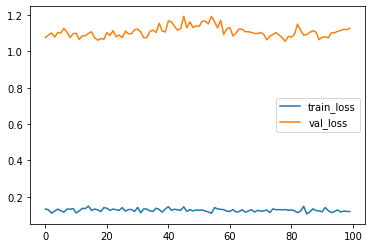

In [63]:
# plot validation curve
history[['train_loss', 'val_loss']].plot();

In [64]:
for i in range(100):
  if history['val_loss'].iloc[i] - history['train_loss'].iloc[i] > 1.0:
    print( i)

6
37
40
41
42
45
46
47
48
49
50
51
52
53
54
55
57
59
60
63
82
98
99


So we can make conclusion that overfitting appears in a lot of cases in this example


###Task 3 (2 points)
Beat the baseline
You can change model architecture and hyperparams as you like

In [ ]:
# TOOD: select hyperparams and model architecture
# TODO: create loaders
# TODO: create model
# TODO: train model

In [65]:
# batch size is an important hyperparameter
# make sure you have enough memory to contain batch data and the model
batch_size = 64

train_loader = DataLoader(TensorDataset(
    torch.from_numpy(X_train).float(), 
    torch.from_numpy(y_train)),
    batch_size=batch_size, 
    shuffle=True # it's important to shuffle train dataset every epoch
    )

val_loader = DataLoader(TensorDataset(
    torch.from_numpy(X_val).float(), 
    torch.from_numpy(y_val)),
    batch_size=batch_size, 
    shuffle=False 
)


test_loader = DataLoader(TensorDataset(
    torch.from_numpy(X_test).float(), 
    torch.from_numpy(y_test)),
    batch_size=batch_size, 
    shuffle=False 
)

In [66]:
history = train(model, train_loader, val_loader, n_epochs=100, 
      criterion=criterion, device=device, checkdir=checkdir)

if history['val_loss'].iloc[-1] - history['train_loss'].iloc[-1] > 1.0:
    print('success!')

epoch 1: 100%|██████████| 57/57 [00:00<00:00, 97.88it/s, loss=0.2400]


validation loss=1.2042


epoch 2: 100%|██████████| 57/57 [00:00<00:00, 100.67it/s, loss=0.2635]


validation loss=1.1975


epoch 3: 100%|██████████| 57/57 [00:00<00:00, 97.47it/s, loss=0.2717]


Early stopping


In [67]:
# load weights from best epoch

idx = np.argmin(history['val_loss'])
state_dict = torch.load(checkdir + '/epoch_%d_val_loss_%f' % (history.epoch.iloc[idx], history.val_loss.iloc[idx]))
model.load_state_dict(state_dict)

# test accuracy

model.eval()
test_acc = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)

        prediction = model(X)
        prediction = prediction.argmax(dim=-1)
        acc = (prediction ==  y.squeeze())
        acc = acc.data.cpu().detach().numpy()
        test_acc.extend( acc )

test_acc = np.mean(test_acc)
print('test accuracy', test_acc)
if test_acc > 0.75:
    print('success!')

test accuracy 0.709
